# Hypothesis 1

In [6]:
import pandas as pd


# Load the combined results CSV file
df = pd.read_csv("data/hypothesis1_df.csv")

# Adjust burned_area to percentage
grid_size = 50 * 50 * 0.8 # due to water_body_ratio=0.2
df["burned_area_percentage%"] = (df["burned_area"] / grid_size) * 100

# Drop the original burned_area column for cleaner analysis (optional)
# df.drop(columns=["burned_area"], inplace=True)

# Convert duration to day-hour format
def convert_to_day_hour(hours):
    days = hours // 24  # Integer division to get days
    remaining_hours = round(hours % 24)  # Remainder to get hours
    return f"{days} days {remaining_hours} hours"

# Apply the conversion to the duration column
df["duration_day_hour"] = df["duration"].apply(convert_to_day_hour)

# Drop the original duration column if no longer needed (optional)
# df.drop(columns=["duration"], inplace=True)

# Display the first few rows to confirm the change
df


,simulation,burned_area,duration,category,burned_area_percentage%,duration_day_hour
0,1,16,25,fire_at_bush,0.80,1 days 1 hours
1,2,1097,241,fire_at_bush,54.85,10 days 1 hours
2,3,293,68,fire_at_bush,14.65,2 days 20 hours
3,4,831,255,fire_at_bush,41.55,10 days 15 hours
4,5,947,304,fire_at_bush,47.35,12 days 16 hours
...,...,...,...,...,...,...
95,46,466,183,fire_at_non_bush,23.30,7 days 15 hours
96,47,1104,285,fire_at_non_bush,55.20,11 days 21 hours
97,48,999,253,fire_at_non_bush,49.95,10 days 13 hours
98,49,248,189,fire_at_non_bush,12.40,7 days 21 hours


In [7]:
# Group by category
grouped = df.groupby("category")

# Calculate mean and standard deviation for burned area and duration
summary_stats = grouped[["burned_area_percentage%", "duration"]].agg(["mean", "std"])
# Convert the duration mean and std into day-hour format
# summary_stats["duration", "mean"] = summary_stats["duration", "mean"].apply(convert_to_day_hour)
# summary_stats["duration", "std"] = summary_stats["duration", "std"].apply(convert_to_day_hour)

print(summary_stats)


                 burned_area_percentage%            duration            
                                    mean        std     mean         std
category                                                                
fire_at_bush                      30.575  17.683217   165.82  101.289178
fire_at_non_bush                  26.281  21.115757   158.18  100.648244


<Figure size 1000x600 with 0 Axes>

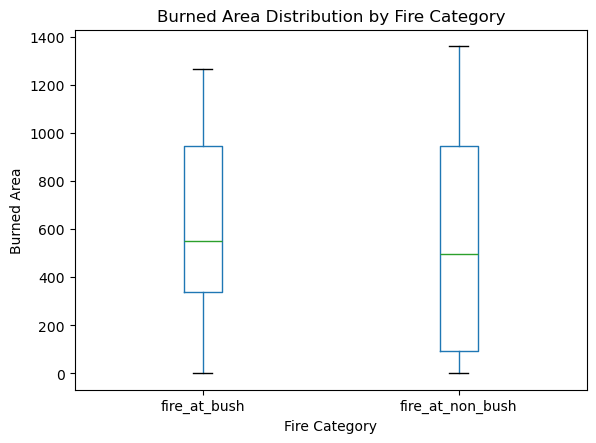

<Figure size 1000x600 with 0 Axes>

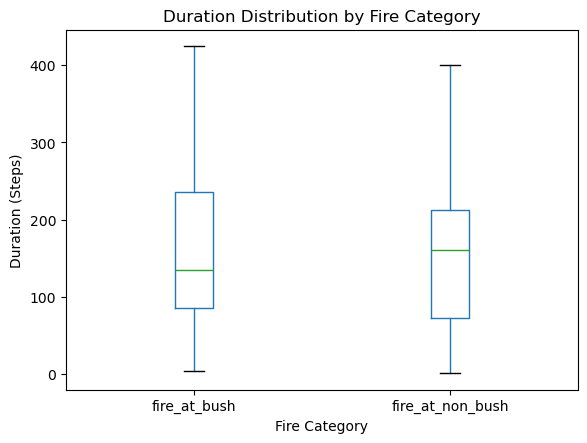

In [8]:
import matplotlib.pyplot as plt

# Box plot for burned area
plt.figure(figsize=(10, 6))
df.boxplot(column="burned_area", by="category", grid=False)
plt.title("Burned Area Distribution by Fire Category")
plt.suptitle("")  # Remove default title
plt.xlabel("Fire Category")
plt.ylabel("Burned Area")
plt.show()

# Box plot for duration
plt.figure(figsize=(10, 6))
df.boxplot(column="duration", by="category", grid=False)
plt.title("Duration Distribution by Fire Category")
plt.suptitle("")  # Remove default title
plt.xlabel("Fire Category")
plt.ylabel("Duration (Steps)")
plt.show()


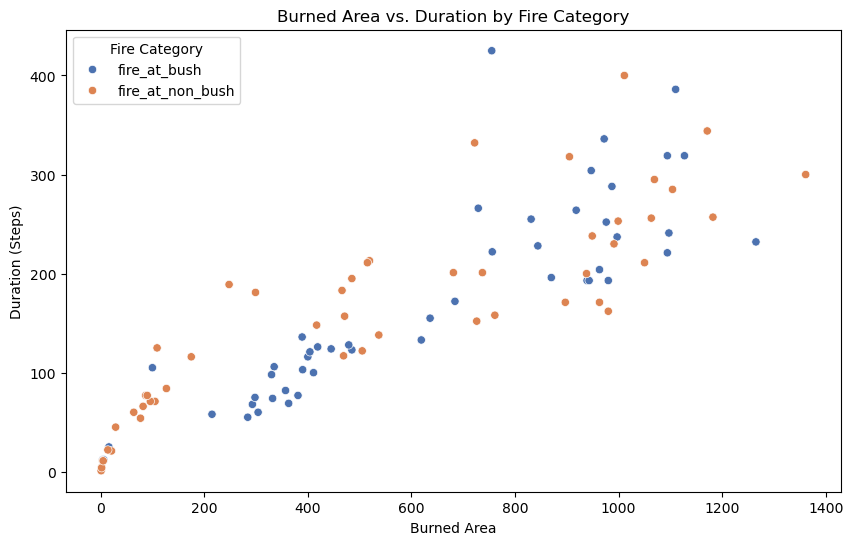

In [9]:
import seaborn as sns

# Scatter plot of burned area vs. duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x="burned_area", y="duration", hue="category", data=df, palette="deep")
plt.title("Burned Area vs. Duration by Fire Category")
plt.xlabel("Burned Area")
plt.ylabel("Duration (Steps)")
plt.legend(title="Fire Category")
plt.show()


# Hypothesis 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def plot_fire_and_water_influence(grid, burn_probabilities):
    # Water cells (grid == 3)
    water_cells = (grid == 3)

    # Calculate the distance to the nearest water
    distances_to_water = distance_transform_edt(~water_cells)

    # Set the maximum influence distance for water and adjust burn probabilities
    max_influence_distance = 5
    influence_factor = np.clip(1 - (distances_to_water / max_influence_distance), 0, 1)

    # Adjust burn probabilities based on water proximity
    adjusted_burn_probabilities = burn_probabilities * (1 - 0.5 * influence_factor)

    # Create visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Burn Probabilities Heatmap
    ax = axes[0]
    img1 = ax.imshow(burn_probabilities, cmap="hot", interpolation="nearest")
    ax.set_title("Burn Probabilities Heatmap")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    cbar1 = plt.colorbar(img1, ax=ax)
    cbar1.set_label("Burn Probability")
    ax.contour(water_cells, colors='blue', linewidths=0.5, linestyles='dashed', label="Water Bodies")
    ax.legend(["Water Bodies"])

    # Plot 2: Distance to Water Heatmap
    ax = axes[1]
    img2 = ax.imshow(distances_to_water, cmap="cool", interpolation="nearest")
    ax.set_title("Distance to Water Heatmap")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    cbar2 = plt.colorbar(img2, ax=ax)
    cbar2.set_label("Distance to Water (Cells)")
    ax.contour(water_cells, colors='blue', linewidths=0.5, linestyles='dashed', label="Water Bodies")
    ax.legend(["Water Bodies"])

    # Plot 3: Boxplot and Statistical Analysis
    ax = axes[2]

    # Extract burn probabilities for cells near water (distance <= 5 cells) and far from water (distance > 5)
    close_to_water = burn_probabilities[distances_to_water <= 5]
    far_from_water = burn_probabilities[distances_to_water > 5]

    # Boxplot
    ax.boxplot([close_to_water, far_from_water], labels=['Close to Water', 'Far from Water'], showfliers=False)
    ax.set_title("Box Plot of Burn Probabilities")
    ax.set_ylabel("Burn Probability")

    # Calculate and print statistics
    stats_close = {
        'mean': np.mean(close_to_water),
        'median': np.median(close_to_water),
        'std': np.std(close_to_water)
    }

    stats_far = {
        'mean': np.mean(far_from_water),
        'median': np.median(far_from_water),
        'std': np.std(far_from_water)
    }

    print("Statistics for cells close to water (distance <= 5 cells):")
    print(f"Mean: {stats_close['mean']:.4f}, Median: {stats_close['median']:.4f}, Std: {stats_close['std']:.4f}")

    print("\nStatistics for cells far from water (distance > 5 cells):")
    print(f"Mean: {stats_far['mean']:.4f}, Median: {stats_far['median']:.4f}, Std: {stats_far['std']:.4f}")

    plt.tight_layout()
    plt.show()

output_file = "data/burn_probabilities.txt"
with open(output_file, "w") as file:
        rows, cols = burn_probabilities.shape
        for r in range(rows):
            row_data = " ".join(f"{burn_probabilities[r, c]:.4f}" for c in range(cols))
            file.write(row_data + "\n")

    file_path = 'data/burn_probabilities.txt'  # Replace with your file path
    data = np.loadtxt(file_path)

    # Ensure there are at least 2500 numbers
    if data.size < 2500:
        raise ValueError("The file must contain at least 2500 numbers to form a 50x50 matrix.")

    # Reshape into a 50x50 matrix
    burn_probabilities = data[:2500].reshape(50, 50)

    plot_fire_and_water_influence(grid, burn_probabilities)

# Hypothesis 3

In [11]:
import pandas as pd

# File paths
file_paths = [
    "wind_speed_comparison_results_0.csv",
    "wind_speed_comparison_results_05.csv",
    "wind_speed_comparison_results_10.csv",
    "wind_speed_comparison_results_20.csv",
    "wind_speed_comparison_results_30.csv",
]

# Read and concatenate all files
df_list = [pd.read_csv(file_path) for file_path in file_paths]
df = pd.concat(df_list, ignore_index=True)

# Check the combined data
df

,simulation,burned_area,duration,wind_speed,wind_direction
0,1,379,76,0,N
1,2,430,116,0,N
2,3,485,109,0,N
3,4,504,86,0,N
4,5,614,175,0,N
...,...,...,...,...,...
245,46,710,91,30,N
246,47,444,76,30,N
247,48,618,86,30,N
248,49,782,92,30,N


In [12]:
# Group by wind_speed and calculate mean and standard deviation for burned_area and duration
summary_stats = df.groupby("wind_speed")[["burned_area", "duration"]].agg(["mean", "std"])
summary_stats

burned_area             duration           
                  mean         std     mean        std
wind_speed                                            
0               647.90  303.530670   135.12  51.528728
5               673.64  299.884315   106.08  37.854631
10              522.68  156.529379    89.02  15.628976
20              541.80  131.472974    85.10   7.987873
30              548.34  169.238464    83.32  18.515785

<Figure size 1000x600 with 0 Axes>

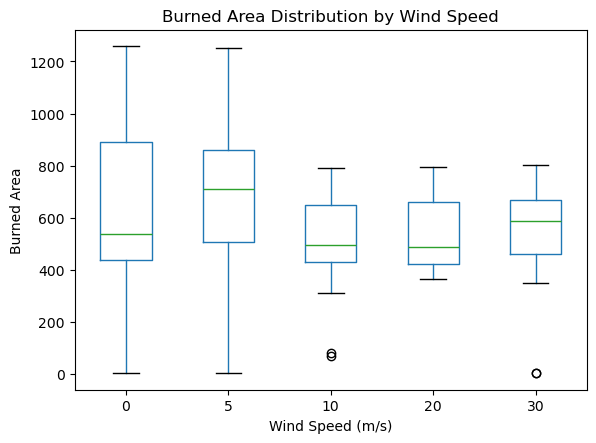

<Figure size 1000x600 with 0 Axes>

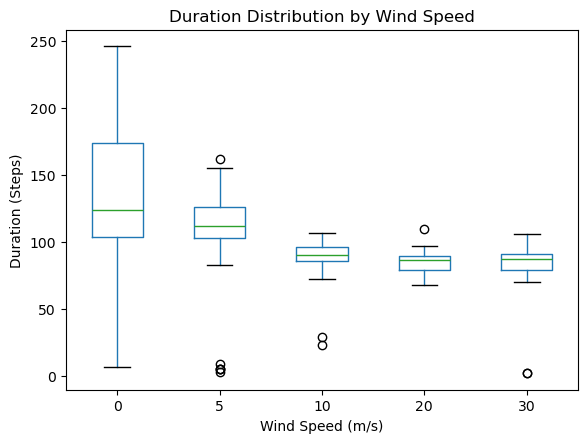

In [13]:
import matplotlib.pyplot as plt

# Box plot for burned area
plt.figure(figsize=(10, 6))
df.boxplot(column="burned_area", by="wind_speed", grid=False)
plt.title("Burned Area Distribution by Wind Speed")
plt.suptitle("")  # Remove default title
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Burned Area")
plt.show()

# Box plot for duration
plt.figure(figsize=(10, 6))
df.boxplot(column="duration", by="wind_speed", grid=False)
plt.title("Duration Distribution by Wind Speed")
plt.suptitle("")  # Remove default title
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Duration (Steps)")
plt.show()

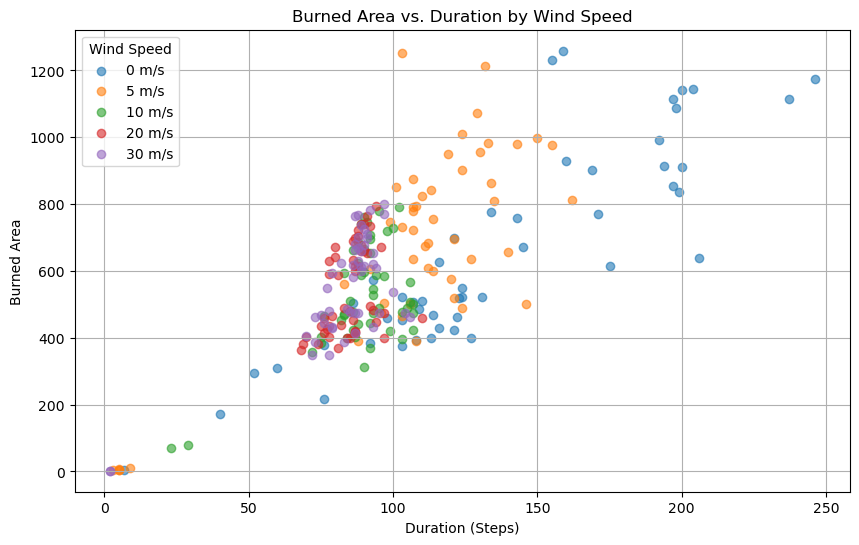

In [14]:
import matplotlib.pyplot as plt

# Scatter plot for burned area vs. duration
plt.figure(figsize=(10, 6))

# Plot for each wind speed
for wind_speed in df["wind_speed"].unique():
    subset = df[df["wind_speed"] == wind_speed]
    plt.scatter(subset["duration"], subset["burned_area"], label=f"{wind_speed} m/s", alpha=0.6)

# Add labels and title
plt.title("Burned Area vs. Duration by Wind Speed")
plt.xlabel("Duration (Steps)")
plt.ylabel("Burned Area")
plt.legend(title="Wind Speed")
plt.grid(True)
plt.show()


In [15]:
from scipy.stats import ttest_ind

# Compare burned area between wind_speed 0 and wind_speed 30 as an example
group_0 = df[df["wind_speed"] == 0]["burned_area"]
group_30 = df[df["wind_speed"] == 30]["burned_area"]

t_stat, p_value = ttest_ind(group_0, group_30, equal_var=False)
print(f"T-Test for Burned Area (0 vs 30 m/s): t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")

# Similarly, compare duration
group_0_duration = df[df["wind_speed"] == 0]["duration"]
group_30_duration = df[df["wind_speed"] == 30]["duration"]

t_stat, p_value = ttest_ind(group_0_duration, group_30_duration, equal_var=False)
print(f"T-Test for Duration (0 vs 30 m/s): t-statistic = {t_stat:.2f}, p-value = {p_value:.3f}")


T-Test for Burned Area (0 vs 30 m/s): t-statistic = 2.03, p-value = 0.046
T-Test for Duration (0 vs 30 m/s): t-statistic = 6.69, p-value = 0.000


# Validation

In [16]:
def describe_data(data, season):
    """
    Print summary statistics of burn probabilities for the given season.
    """
    print(f"Descriptive Statistics for {season.capitalize()} Season:")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Standard Deviation: {np.std(data):.4f}")
    print(f"Min: {np.min(data):.4f}")
    print(f"Max: {np.max(data):.4f}")
    print(f"25th Percentile: {np.percentile(data, 25):.4f}")
    print(f"50th Percentile (Median): {np.percentile(data, 50):.4f}")
    print(f"75th Percentile: {np.percentile(data, 75):.4f}")
    print("-" * 40)

def plot_heatmap_and_boxplot(winter_data, summer_data, grid_size=(50, 50)):
    """
    Plots a heatmap of burn probabilities for both winter and summer seasons and
    a boxplot to compare the distribution of burn probabilities for both seasons.
    """
    # 1. Heatmap of Burn Probabilities
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Winter Heatmap
    ax = axes[0]
    ax.imshow(winter_data.reshape(grid_size), cmap='hot', interpolation='nearest')
    ax.set_title("Winter Season Burn Probabilities")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    cbar = plt.colorbar(ax.imshow(winter_data.reshape(grid_size), cmap='hot', interpolation='nearest'), ax=ax)
    cbar.set_label("Burn Probability")

    # Summer Heatmap
    ax = axes[1]
    ax.imshow(summer_data.reshape(grid_size), cmap='hot', interpolation='nearest')
    ax.set_title("Summer Season Burn Probabilities")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    cbar = plt.colorbar(ax.imshow(summer_data.reshape(grid_size), cmap='hot', interpolation='nearest'), ax=ax)
    cbar.set_label("Burn Probability")

    plt.tight_layout()
    plt.show()

    # 2. Boxplot of Burn Probabilities
    # Reshaping the 1D data into 2D to pass into boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot([winter_data.flatten(), summer_data.flatten()], labels=["Winter", "Summer"])
    ax.set_title("Burn Probability Distribution")
    ax.set_ylabel("Burn Probability")
    plt.show()